In [1]:
import numpy as np
import qiskit
import qiskit_aer
import qiskit.visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
from qiskit_ibm_runtime.fake_provider import FakePerth
fakebackend = FakePerth()

In [3]:
def circmake(probe,groups,backend):

    circs=[]

    
    j = 0
    while j <groups:
        i = 0
        while i<11:
        
            circ = qiskit.QuantumCircuit(qiskit.QuantumRegister(1, name="Meter_Z"),
                      qiskit.QuantumRegister(1, name="System"),
                      qiskit.QuantumRegister(1, name="Probe_X"),
                      qiskit.QuantumRegister(1, name="Probe_Z"),
                      qiskit.ClassicalRegister(4, name="readout"))



            mez=np.arccos(0.0+0.1*i)


            circ.rz(-np.pi,1)
            circ.sx(1)
            circ.rz(-np.pi,1)
            circ.barrier()

            circ.rz(-np.pi,3)
            circ.sx(3)
            circ.rz(np.pi-np.arccos(probe),3)
            circ.sx(3)

            circ.cx(1,3)

            circ.barrier()
            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)

            circ.rz(-np.pi,2)
            circ.sx(2)
            circ.rz(np.pi-np.arccos(probe),2)
            circ.sx(2)

            circ.cx(1,2)

            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)

            circ.barrier()
            circ.rz(-np.pi,0)
            circ.sx(0)
            circ.rz(np.pi-mez,0)
            circ.sx(0)

            circ.cx(1,0)


            circ.barrier()
            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)
    
            circ.measure([0,1,2,3],[1,0,2,3])
            circ=qiskit.compiler.transpile(circ,backend=backend,optimization_level=1)
            circs.append(circ)
            i += 1
        j+= 1
    
    return circs

In [4]:
def make_noise_backend(prob_1,prob_2,prob_r):
    cnoise_model = qiskit_aer.noise.NoiseModel(basis_gates=['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x'])
    if prob_1:
        error_1 = qiskit_aer.noise.depolarizing_error(prob_1, 1)
        cnoise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x',"id"])
    if prob_2:
        error_2 = qiskit_aer.noise.depolarizing_error(prob_2, 2)
        cnoise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    if prob_r:
        error_r = qiskit_aer.noise.ReadoutError(prob_r)
        cnoise_model.add_all_qubit_readout_error(error_r)
    simbackend = qiskit_aer.AerSimulator(noise_model=cnoise_model,method='density_matrix')
    return simbackend

In [5]:
def get_ed(raw):
    err_raw = qiskit.result.marginal_counts(raw,indices=[1,3]).get_counts()
    dis_raw = qiskit.result.marginal_counts(raw,indices=[0,2]).get_counts()
    error = np.zeros([groups,11])
    i = 0
    while i < groups:
        j = 0
        while j < 11:
            a = (np.sqrt(2*abs(1-(err_raw[i*11+j]['00']+err_raw[i*11+j]['11']-err_raw[i*11+j]['01']-err_raw[i*11+j]['10'])/shots/0.1)))
            error[i][j] = a
            j += 1
        i += 1
    
    disturb = np.zeros([groups,11])
    i = 0
    while i < groups:
        j = 0
        while j < 11:
            a = (np.sqrt(2*abs(1-(dis_raw[i*11+j]['00']+dis_raw[i*11+j]['11']-dis_raw[i*11+j]['01']-dis_raw[i*11+j]['10'])/shots/0.1)))
            disturb[i][j] = a
            j += 1
        i += 1
    return error.transpose(), disturb.transpose()

In [6]:
def get_plot_data(raw_error,raw_disturb):
    result = np.zeros([4,11]) 
    i = 0
    while i <11 :
        result[0,i]= (np.sum(raw_error[i])-np.max(raw_error[i])-np.min(raw_error[i]))/(groups-2)
        result[2,i]= (np.sum(raw_disturb[i])-np.max(raw_disturb[i])-np.min(raw_disturb[i]))/(groups-2)
        #result[0,i]= np.mean(raw_error[i])
        #result[2,i]= np.mean(raw_disturb[i])
        result[1,i]= np.std(raw_error[i],ddof=1)
        result[3,i]= np.std(raw_disturb[i],ddof=1)
        i += 1
    return result

In [17]:
def measurement_strength_plot(sim_result):
    E=np.linspace(0,1,1001)
    plt.figure(figsize=(15,10))
    Thes = np.linspace(0,1,21)
    strength = np.linspace(0,10,11)

    plt.plot(E,np.sqrt(2*(1-E)),color='#0000de',lw=3,label='Theoretical error')
    plt.plot(E,np.sqrt(2*(1-np.sin(np.arccos(E)))),color='#de0000',lw=3,label='Theoretical disturbance')

    plt.errorbar(strength/10,sim_result[0], yerr=sim_result[1], elinewidth=1 ,color="g",fmt="^",ms=15,mec="g",capsize=5,capthick=2,label='Simulated error')
    plt.errorbar(strength/10,sim_result[2], yerr=sim_result[3], elinewidth=1 ,color="purple",fmt="d",ms=17,mec="purple",capsize=5,capthick=2,label='Simulated disturbance')


    order = [2,0,3,1]
    handles, labels = plt.gca().get_legend_handles_labels()
    #add legend to plot
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(0.87,-0.17),loc='upper right',fontsize=22,ncol=2) 
    plt.legend(bbox_to_anchor=(0.97,-0.17),loc='upper right',fontsize=22,ncol=2)
    plt.xlabel("Measurement Strength (cos ${\\theta}$)",size=32,labelpad=24)
    plt.ylabel("Error and Disturbance",size=32,labelpad=18)
    plt.tick_params(labelsize=32)
    plt.grid(True)
    plt.show()

In [30]:
def forbidden_zone_plot(sim_result):
    plt.figure(figsize=(15,15))

    b = np.linspace(0.5,1.8,1000)
    c = np.linspace(0.001,1,1000)


    plt.errorbar(sim_result[0],sim_result[2], xerr=sim_result[1],yerr=sim_result[3], elinewidth=2 ,color="black",capsize=5,capthick=2,fmt="o",ms=12,mec="b")


    x = np.linspace(-2, 2, 1000)

    x = np.linspace(-2, 2, 1000)
    y = np.linspace(-2, 2, 1000)
    X, Y = np.meshgrid(x, y)


    Z = np.sqrt((X**2 - X**4/4) + (Y**2 - Y**4/4))


    plt.contourf(X, Y, Z, levels=[1, Z.max()], colors='y', alpha=0.22)


    plt.contour(X, Y, Z, levels=[1], colors='blue',linewidths=4,linestyles="--")
    plt.plot(c,(1-c)/(1+c),lw=4,color="black")

    plt.plot(b,1/b,lw=4,color="purple")

    plt.plot(c,np.sqrt(1-c*c),lw=4,color="r")



    plt.fill_between(c,(1-c)/(1+c),color="gray",alpha=0.3)
    plt.fill_between(c,(1-c)/(1+c),np.sqrt(1-c*c),color="b",alpha=0.3)
    plt.fill_between(b,1/b,999,color="w",alpha=1)
    plt.fill_between(b,1/b,999,color="g",alpha=0.4)
    plt.xlim(0,1.6)
    plt.ylim(0,1.6)

    #plt.legend(bbox_to_anchor=(0.97,-0.12),loc='upper right',fontsize=22,ncol=2)
    plt.xlabel("Error",size=32)
    plt.ylabel("Disturbance",size=32)
    plt.tick_params(labelsize=32)
    plt.show()

In [33]:
shots=10000
probe_strength = 0.1
groups = 100

qnoise_model = qiskit_aer.noise.NoiseModel.from_backend(fakebackend,temperature=50) 
qsimbackend = qiskit_aer.AerSimulator(noise_model=qnoise_model,method='density_matrix')

csimbackend = make_noise_backend(0.001,0.01,[[0.96,0.04],[0.04,0.96]])


In [34]:
circs = circmake(probe_strength,groups)
sim_job= csimbackend.run(circs,shots=shots).result()
raw_error,raw_disturb = get_ed(sim_job)
sim_result = get_plot_data(raw_error,raw_disturb)

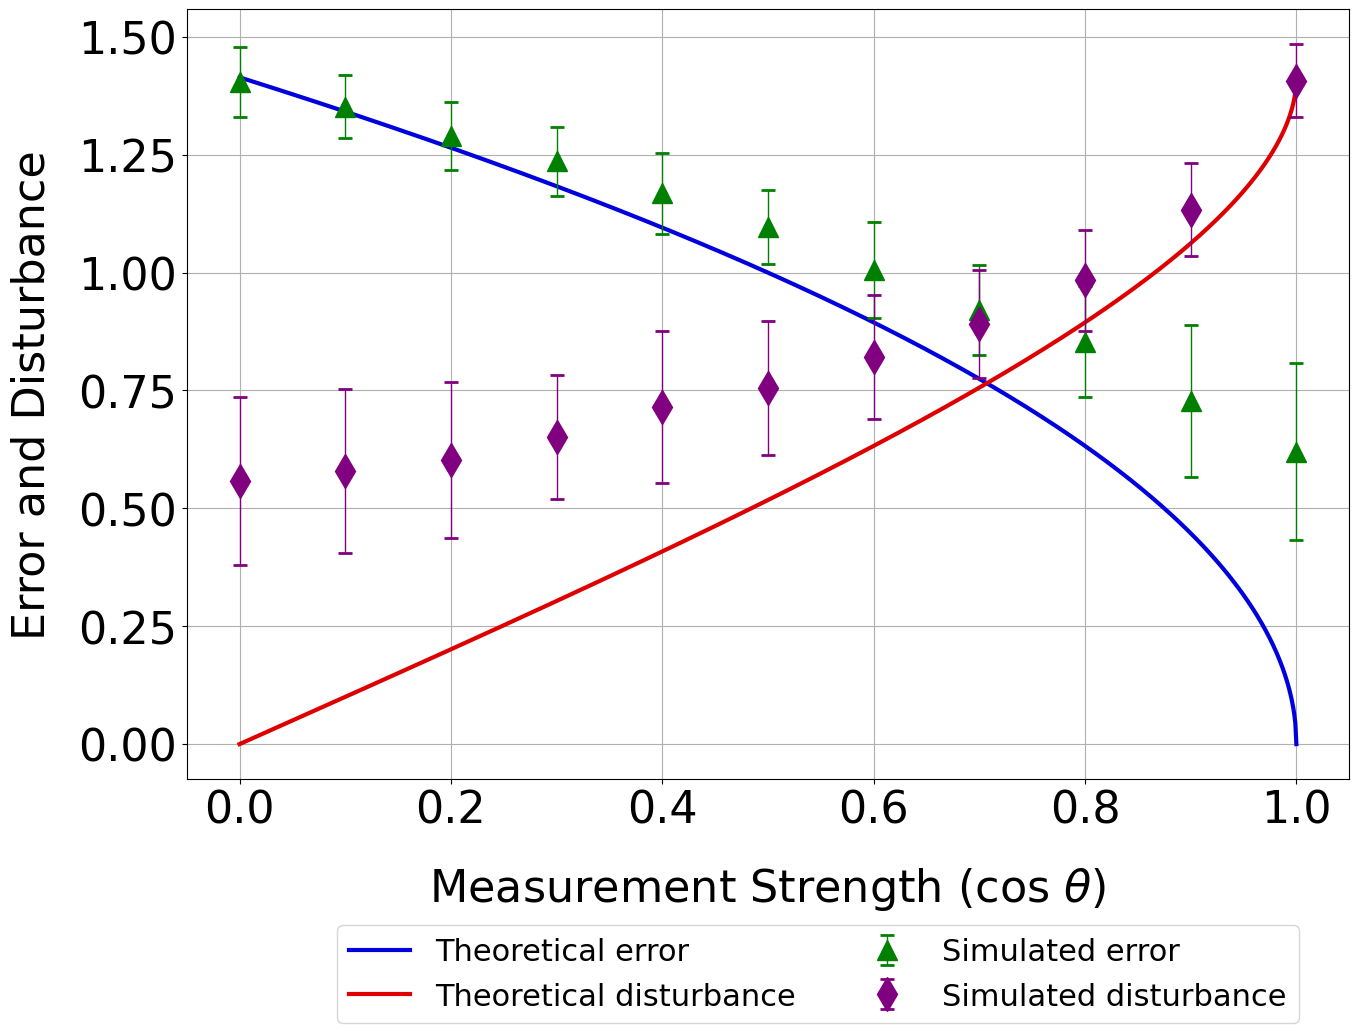

In [35]:
measurement_strength_plot(sim_result)

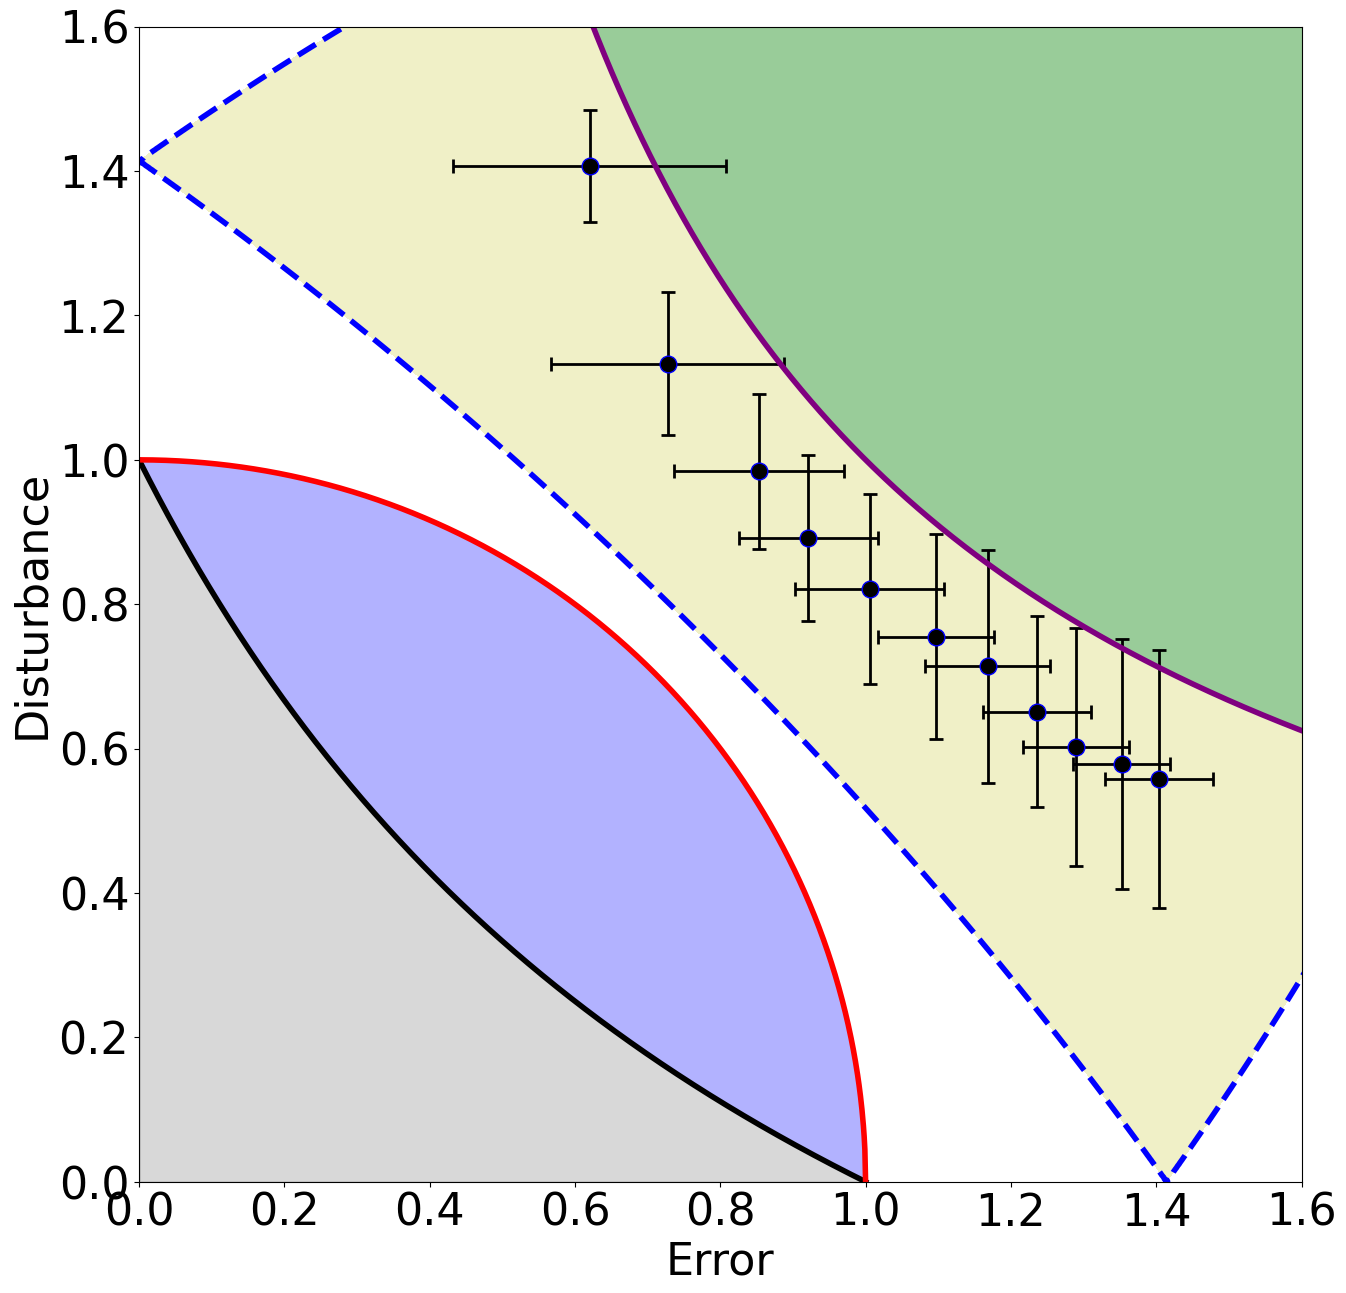

In [36]:
forbidden_zone_plot(sim_result)